# Implémentez un modèle de scoring

*Notebook modélisation*

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

**Mission :**

- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

- Analyser les features qui contribuent le plus au modèle, d’une manière générale (feature importance globale) et au niveau d’un client (feature importance locale), afin, dans un soucis de transparence, de permettre à un chargé d’études de mieux comprendre le score attribué par le modèle.

- Mettre en production le modèle de scoring de prédiction à l’aide d’une API et réaliser une interface de test de cette API.

- Mettre en œuvre une approche globale MLOps de bout en bout, du tracking des expérimentations à l’analyse en production du data drift.
    + Dans le notebook d’entraînement des modèles, générer à l’aide de MLFlow un tracking d'expérimentations
    + Lancer l’interface web 'UI MLFlow" d'affichage des résultats du tracking
    + Réaliser avec MLFlow un stockage centralisé des modèles dans un “model registry”
    + Tester le serving MLFlow
    + Gérer le code avec le logiciel de version Git
    + Partager le code sur Github pour assurer une intégration continue
    + Utiliser Github Actions pour le déploiement continu et automatisé du code de l’API sur le cloud
    + Concevoir des tests unitaires avec Pytest (ou Unittest) et les exécuter de manière automatisée lors du build réalisé par Github Actions

## 1 - Préparer l'environnement d'expérimentation

### 1.1 - Imports

In [110]:
import mlflow
import mlflow.tracking
from mlflow.models import infer_signature

import numpy as np
import pandas as pd

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("mlflow version", mlflow.__version__)
print("sklearn version", sklearn.__version__)

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 200
pd.options.display.max_columns = 130

numpy version 1.26.4
pandas version 2.1.4
mlflow version 2.20.1
sklearn version 1.6.1


### 1.2 - Lancement du serveur MLFlow

Dans le terminal de Powershell Prompt d'Anaconda, lancer cette instruction :

mlflow server --host 127.0.0.1 --port 5000 --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns

Cette commande permet de :
- Stocker les métadonnées du Model Registry dans une base de données locale SQLite.
- Stocker les artefacts (modèles, fichiers) en local.

### 1.3 - Initialisation du Tracking MLFlow de test

In [6]:
import os

# Ignorer Git
os.environ['GIT_PYTHON_REFRESH'] = 'quiet'

# Vérification si la variable d'environnement est bien définie
print(os.environ.get('GIT_PYTHON_REFRESH'))

quiet


In [7]:
# Définir le serveur de tracking (local ou distant) - ici local
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Démarrer une nouvelle expérimentation
mlflow.set_experiment("modele_test_quickstart_0")

2025/02/06 11:21:08 INFO mlflow.tracking.fluent: Experiment with name 'modele_test_quickstart_0' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///C:/Users/admin/mlruns/6', creation_time=1738837268010, experiment_id='6', last_update_time=1738837268010, lifecycle_stage='active', name='modele_test_quickstart_0', tags={}>

### 1.4 - Création d'un modèle pour tester l'initialisation

In [9]:
# Charger les données Iris (pour la démonstration)
data = load_iris()
X = data.data
y = data.target

# Diviser les données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model hyperparameters
params = {
    "random_state": 42,
}

# Initialiser le modèle
model = LogisticRegression(**params)

# Entraînement du modèle
model.fit(X_train, y_train)
    
# Faire des prédictions sur le jeu de test
y_pred = model.predict(X_test)
#y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilités pour AUC binaire
y_pred_prob = model.predict_proba(X_test)  # Probabilités pour AUC

# Calculer accuracy et AUC
accuracy = accuracy_score(y_test, y_pred)
# auc = roc_auc_score(y_test, y_pred_prob) --> si le problème était binaire
auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='macro')

### 1.5 - Enregistrer le modèle et ses métadonnées dans MLflow**

In [11]:
# Démarrer une expérimentation dans MLflow
with mlflow.start_run():

    # Log the hyperparameters
    mlflow.log_params(params)
    
    # Loguer les métriques
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("auc", auc)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Basic LR model for iris data")

    # Infer the model signature
    signature = infer_signature(X_train, model.predict(X_train))
    
    # Loguer le modèle
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="iris_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="modele_test_quickstart_0",
    )
    
    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}")

# Ajouter au Model Registry
#model_version = mlflow.register_model(model_info.model_uri, "test_init_quickstart")

print(f"Modèle enregistré en version {model_info.mlflow_version}")

Successfully registered model 'modele_test_quickstart_0'.
2025/02/06 11:21:17 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: modele_test_quickstart_0, version 1


Accuracy: 1.0
AUC: 1.0
🏃 View run traveling-hound-667 at: http://127.0.0.1:5000/#/experiments/6/runs/0134799111874d9ea53676b7c53eea3a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/6
Modèle enregistré en version 2.20.1


Created version '1' of model 'modele_test_quickstart_0'.


**Lister les versions du modèle**

In [13]:
client = mlflow.tracking.MlflowClient()
versions = client.get_latest_versions("modele_test_quickstart_0")
for v in versions:
    print(f"Version: {v.version}, Statut: {v.current_stage}")

Version: 1, Statut: None


### 1.6 - Chargez le modèle en tant que fonction Python, et l'utiliser pour une prédiction

In [15]:
from sklearn import datasets

# Load the model back for predictions as a generic Python Function model
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

predictions = loaded_model.predict(X_test)

iris_feature_names = datasets.load_iris().feature_names

result = pd.DataFrame(X_test, columns=iris_feature_names)
result["actual_class"] = y_test
result["predicted_class"] = predictions

result[:4]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),actual_class,predicted_class
0,6.1,2.8,4.7,1.2,1,1
1,5.7,3.8,1.7,0.3,0,0
2,7.7,2.6,6.9,2.3,2,2
3,6.0,2.9,4.5,1.5,1,1


### 1.7 - Lancement de l'UI

Pour  la visualisation et la comparaison des expérimentations, ainsi que le stockage de manière centralisée des modèles.

Cliquer sur ce lien : http://127.0.0.1:5000/

### 1.8 - Initialisation du Tracking MLFlow de la mission

In [ ]:
# Définir le serveur de tracking (local ou distant) - ici local
mlflow.set_tracking_uri("http://127.0.0.1:5000")
 
# Démarrer une nouvelle expérimentation
mlflow.set_experiment("modele_scoring")

## 2 - Analyser le jeu de données

### 2.1 - Charger les données du fichier application_...

In [58]:
# Training data
app_train = pd.read_csv('C:/Users/admin/Documents/Projets/Projet_7/data_projet/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the TARGET (the label we want to predict)

In [31]:
# Testing data features
app_test = pd.read_csv('C:/Users/admin/Documents/Projets/Projet_7/data_projet/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


La colonne TARGET n'est pas présente dans le jeu de test.

### 2.2 - Analyser la distribution de la variable cible TARGET

In [34]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

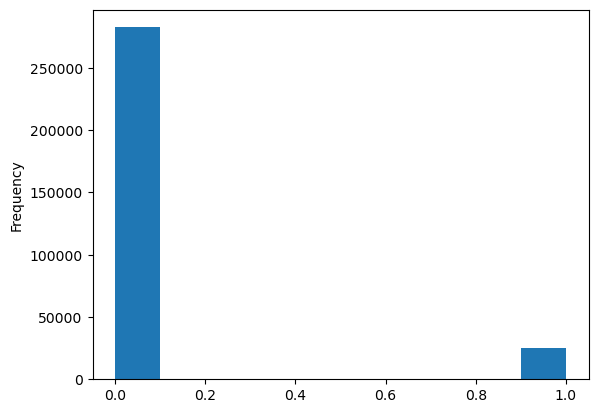

In [38]:
app_train['TARGET'].astype(int).plot.hist();

Il y a un déséquilibre important entre les 2 classes :
- 0 : le prêt a été remboursé
- 1 : le prêt n'a pas été remboursé.

Il y a plus de prêts remboursés que de prêts non remboursés.

### 2.3 - Examiner les valeurs manquantes

In [80]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [93]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(70)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [95]:
# Missing values statistics
missing_values = missing_values_table(app_test)
missing_values.head(70)

Your selected dataframe has 121 columns.
There are 64 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MODE,33495,68.7
COMMONAREA_MEDI,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


### 2.4 - Examiner les types de colonnes

In [74]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [76]:
# Number of each type of column
app_test.dtypes.value_counts()

float64    65
int64      40
object     16
Name: count, dtype: int64

La différence porte sur l'absence de la variable TARGET dans le fichier test.

Regardons le nombre de valeurs uniques dans les colonnes de type object:

In [97]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [100]:
# Number of unique classes in each object column
app_test.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

On voit déjà que dans le fichier de test il y a moins de cas. Par exemple pour CODE_GENDER et NAME_INCOME_TYPE.

La plupart des variables catégorielles ont un nombre relativement faible d'entrées uniques. Nous devons transformer ces catégories en variable numérique via un processus d'encodage : étiquettes (label) versus one-hot.

Le problème avec le codage des étiquettes est qu'il donne aux catégories un ordre arbitraire.

Nous utiliserons le codage d'étiquettes (LabelEncoder) pour toutes les variables catégorielles avec seulement 2 catégories, et le codage one-hot (get_dummies de pandas) pour toutes les variables catégorielles avec plus de 2 catégories.

### 2.5 - Encoder les variables catégorielles

In [112]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [114]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


**Alignement des données d'entraînement et de test**

Les données d'entraînement et de test doivent contenir les mêmes caractéristiques (colonnes). L'encodage one-hot a créé plus de colonnes dans les données d'entraînement car il y avait des variables catégorielles avec des catégories non représentées dans les données de test. 

Pour supprimer les colonnes des données d'entraînement qui ne sont pas dans les données de test, nous devons aligner les dataframes. 

Nous extrayons d'abord la colonne cible des données d'entraînement (car elle ne se trouve pas dans les données de test mais nous devons conserver ces informations). Lorsque nous effectuons l'alignement, nous devons nous assurer de définir axis = 1 pour aligner les dataframes en fonction des colonnes et non des lignes !

In [117]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


Le nombre de features a beaucoup augmenté suite à l'encodage one-hot. Il faudra prévoir une réduction de dimensions avec l'ACP.

### 2.6 - Poursuivre l'analyse exploratoire